In [4]:
%run supervised_functions.ipynb

# Generate data

In [5]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [ ]:
np.random.seed(42)

N = 100000
steps = 5

df_list = []
final_shape = 0
smiles_per_random_sample = 1000
pool_chunk_size = 10

# Create dataset for multi-step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

        for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

  6%|███▌                                                   | 64775/1000000 [01:05<15:40, 994.84it/s]

# Load/build stuff

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Action embedings

In [ ]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

#### Indices (for faster access)

In [ ]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

# Training

In [ ]:
train_idx = np.arange(0, int(main_df.shape[0]*0.8))
test_idx = np.arange(int(main_df.shape[0]*0.8), main_df.shape[0])

train_idx = torch.arange(0, int(main_df.shape[0]*0.8))[:500]
test_idx = torch.arange(int(main_df.shape[0]*0.8), main_df.shape[0])[-200:]

In [1]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)
train_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["rsig"]))).to(device)
train_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["psig"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["rsig"]))).to(device)
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["psig"]))).to(device)

print(train_reactants.batch_size, train_products.batch_size, train_rsigs.batch_size, train_psigs.batch_size)
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size)

NameError: name 'data' is not defined

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Training for actor loss = mse


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.81it/s]


Epoch 1/50. Batch 86400/86456. Actor loss = 0.068441 || critic loss = 0.017579

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 4.1438 │  0.799672 │         114.486 │        290.172 │        338.076 │         105.648 │        274.983 │        338.076 │ 10.40 min               │
╘════╧════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.18it/s]


BEST MODEL UPDATED! BEST RANK = 114.48566937869822
Epoch 2/50. Batch 86400/86456. Actor loss = 0.063200 || critic loss = 0.017624

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 4.15703 │  0.817761 │         116.472 │        292.406 │        338.076 │         105.459 │        272.505 │        338.076 │ 10.28 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.38it/s]


Epoch 3/50. Batch 86400/86456. Actor loss = 0.057066 || critic loss = 0.017855

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 4.10403 │  0.818894 │         119.023 │         299.07 │        338.076 │         106.664 │        277.339 │        338.076 │ 10.41 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.23it/s]


Epoch 4/50. Batch 86400/86456. Actor loss = 0.049975 || critic loss = 0.014673

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 3.92721 │  0.818076 │         118.978 │        297.444 │        338.076 │         107.542 │         282.43 │        338.076 │ 10.33 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.30it/s]


Epoch 5/50. Batch 86400/86456. Actor loss = 0.044532 || critic loss = 0.013598

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 3.8214 │  0.817885 │         117.771 │        298.799 │        338.076 │         105.879 │        284.789 │        338.076 │ 10.34 min               │
╘════╧════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.12it/s]


Epoch 6/50. Batch 86400/86456. Actor loss = 0.041396 || critic loss = 0.013921

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 3.78212 │  0.814384 │         120.529 │        302.753 │        338.076 │         107.983 │        287.898 │        338.076 │ 10.33 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.70it/s]


Epoch 7/50. Batch 86400/86456. Actor loss = 0.037984 || critic loss = 0.015792

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 3.67198 │  0.812931 │         119.462 │        304.618 │        338.076 │         106.793 │        288.497 │        338.076 │ 10.38 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.95it/s]


Epoch 8/50. Batch 86400/86456. Actor loss = 0.034783 || critic loss = 0.014355

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 3.65237 │  0.808237 │         117.538 │        303.816 │        338.076 │         103.403 │        283.543 │        338.076 │ 10.27 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.34it/s]


Epoch 9/50. Batch 86400/86456. Actor loss = 0.033409 || critic loss = 0.016431

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 3.54449 │  0.806382 │         115.096 │        298.589 │        338.076 │         101.327 │        278.495 │        338.076 │ 10.66 min               │
╘════╧═════════╧═══════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.90it/s]


Epoch 10/50. Batch 86400/86456. Actor loss = 0.030728 || critic loss = 0.012897

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 3.48202 │  0.805241 │         112.766 │        293.517 │        338.076 │         97.9118 │        272.487 │        338.076 │ 10.40 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.99it/s]


BEST MODEL UPDATED! BEST RANK = 112.76622596153847
Epoch 11/50. Batch 86400/86456. Actor loss = 0.030151 || critic loss = 0.016861

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 3.46766 │  0.802135 │         110.167 │        290.495 │        338.076 │         95.4144 │        268.841 │        338.076 │ 10.24 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.86it/s]


BEST MODEL UPDATED! BEST RANK = 110.16729844674556
Epoch 12/50. Batch 86400/86456. Actor loss = 0.028297 || critic loss = 0.018744

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 3.40633 │  0.801353 │          109.53 │        289.428 │        338.076 │         94.7269 │        267.707 │        338.076 │ 10.18 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.46it/s]


BEST MODEL UPDATED! BEST RANK = 109.52958579881657
Epoch 13/50. Batch 86400/86456. Actor loss = 0.026244 || critic loss = 0.016075

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 3.3449 │  0.798753 │         108.009 │        286.622 │        338.076 │         93.1341 │        264.048 │        338.076 │ 10.07 min       

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


BEST MODEL UPDATED! BEST RANK = 108.00855214497041
Epoch 14/50. Batch 86400/86456. Actor loss = 0.025599 || critic loss = 0.017107

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 3.27934 │   0.79995 │         106.691 │        284.227 │        338.076 │         92.2628 │        261.689 │        338.076 │ 10.11 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.65it/s]


BEST MODEL UPDATED! BEST RANK = 106.69147559171597
Epoch 15/50. Batch 86400/86456. Actor loss = 0.024577 || critic loss = 0.015909

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 3.25783 │  0.799237 │         105.233 │        282.307 │        338.076 │         90.5137 │        259.991 │        338.076 │ 10.03 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.59it/s]


BEST MODEL UPDATED! BEST RANK = 105.23326553254438
Epoch 16/50. Batch 86400/86456. Actor loss = 0.023909 || critic loss = 0.019126

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 3.25035 │  0.795618 │         106.111 │        284.747 │        338.076 │         90.7751 │        259.719 │        338.076 │ 10.01 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.55it/s]


Epoch 17/50. Batch 86400/86456. Actor loss = 0.022659 || critic loss = 0.017967

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 3.1962 │  0.798589 │         103.427 │        278.328 │        338.076 │         88.0012 │        253.432 │        338.076 │ 10.10 min               │
╘════╧════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.69it/s]


BEST MODEL UPDATED! BEST RANK = 103.42709874260355
Epoch 18/50. Batch 86400/86456. Actor loss = 0.021671 || critic loss = 0.018921

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 3.19747 │  0.796276 │         104.032 │         279.88 │        338.076 │         89.1567 │        255.611 │        338.076 │ 9.99 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


Epoch 19/50. Batch 86400/86456. Actor loss = 0.021357 || critic loss = 0.017635

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 3.15087 │  0.797365 │         104.997 │        283.295 │        338.076 │         90.0875 │        260.885 │        338.076 │ 9.97 min                │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.90it/s]


Epoch 20/50. Batch 86400/86456. Actor loss = 0.020368 || critic loss = 0.017180

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 3.13046 │  0.795535 │         105.061 │         282.56 │        338.076 │         89.7658 │        261.389 │        338.076 │ 9.99 min                │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.82it/s]


Epoch 21/50. Batch 86400/86456. Actor loss = 0.019448 || critic loss = 0.015146

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 3.08827 │  0.795753 │         103.497 │         279.95 │        338.076 │         88.1949 │        258.352 │        338.076 │ 9.98 min                │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.20it/s]


Epoch 22/50. Batch 86400/86456. Actor loss = 0.019173 || critic loss = 0.012673

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 3.06281 │  0.794193 │         102.773 │        278.284 │        338.076 │          87.626 │         255.19 │        338.076 │ 10.01 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.84it/s]


BEST MODEL UPDATED! BEST RANK = 102.77279031065089
Epoch 23/50. Batch 86400/86456. Actor loss = 0.018359 || critic loss = 0.012600

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 3.03578 │  0.795256 │         100.846 │        277.517 │        338.076 │         86.1603 │        255.446 │        338.076 │ 9.99 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


BEST MODEL UPDATED! BEST RANK = 100.84573779585799
Epoch 24/50. Batch 86400/86456. Actor loss = 0.018196 || critic loss = 0.012267

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │ 3.03935 │   0.79314 │         102.773 │        280.285 │        338.076 │         87.1087 │        256.162 │        338.076 │ 9.91 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.75it/s]


Epoch 25/50. Batch 86400/86456. Actor loss = 0.017508 || critic loss = 0.011426

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 3.00242 │  0.795136 │         102.244 │        279.361 │        338.076 │         87.2937 │        257.673 │        338.076 │ 10.00 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.83it/s]


Epoch 26/50. Batch 86400/86456. Actor loss = 0.017352 || critic loss = 0.010997

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 3.01042 │  0.795167 │         103.947 │        284.883 │        338.076 │          88.345 │        260.652 │        338.076 │ 10.12 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.61it/s]


Epoch 27/50. Batch 86400/86456. Actor loss = 0.017321 || critic loss = 0.010666

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 2.97915 │  0.795765 │         103.262 │          284.2 │        338.076 │         88.7174 │        262.856 │        338.076 │ 10.08 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.22it/s]


Epoch 28/50. Batch 86400/86456. Actor loss = 0.016868 || critic loss = 0.008402

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 2.94868 │  0.796609 │         102.229 │        281.356 │        338.076 │         87.1266 │        259.872 │        338.076 │ 10.24 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.60it/s]


Epoch 29/50. Batch 86400/86456. Actor loss = 0.016789 || critic loss = 0.008875

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 2.98915 │  0.794664 │         103.299 │        285.116 │        338.076 │         89.2942 │        262.782 │        338.076 │ 10.30 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.58it/s]


Epoch 30/50. Batch 86400/86456. Actor loss = 0.015642 || critic loss = 0.008563

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 2.94573 │   0.79465 │         100.783 │        278.343 │        338.076 │         86.1959 │        255.016 │        338.076 │ 10.30 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.14it/s]


BEST MODEL UPDATED! BEST RANK = 100.78323779585799
Epoch 31/50. Batch 86400/86456. Actor loss = 0.015739 || critic loss = 0.007377

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 2.93988 │  0.792917 │         101.404 │        280.401 │        338.076 │         86.9117 │        255.878 │        338.076 │ 10.12 min   

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.11it/s]


Epoch 32/50. Batch 86400/86456. Actor loss = 0.015601 || critic loss = 0.010152

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 2.92472 │  0.794271 │         101.753 │        279.636 │        338.076 │          87.619 │        258.473 │        338.076 │ 10.14 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.49it/s]


Epoch 33/50. Batch 86400/86456. Actor loss = 0.015361 || critic loss = 0.008144

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 2.93368 │  0.792768 │         101.348 │        281.484 │        338.076 │         85.8532 │        257.085 │        338.076 │ 10.18 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.53it/s]


Epoch 34/50. Batch 86400/86456. Actor loss = 0.014933 || critic loss = 0.008725

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 2.91273 │  0.793672 │         100.935 │        281.564 │        338.076 │         86.7693 │        259.653 │        338.076 │ 10.16 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.72it/s]


Epoch 35/50. Batch 86400/86456. Actor loss = 0.014833 || critic loss = 0.009580

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 2.93401 │   0.79336 │         99.4834 │         278.86 │        338.076 │         85.4055 │        256.063 │        338.076 │ 10.15 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.24it/s]


BEST MODEL UPDATED! BEST RANK = 99.48335798816568
Epoch 36/50. Batch 86400/86456. Actor loss = 0.014613 || critic loss = 0.010501

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 2.89893 │  0.793347 │         99.6496 │        278.124 │        338.076 │         85.2868 │        256.135 │        338.076 │ 10.22 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.28it/s]


Epoch 37/50. Batch 86400/86456. Actor loss = 0.014409 || critic loss = 0.005576

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 2.92039 │  0.792882 │         98.9371 │        277.846 │        338.076 │         85.5288 │        258.311 │        338.076 │ 10.18 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.37it/s]


BEST MODEL UPDATED! BEST RANK = 98.93713017751479
Epoch 38/50. Batch 86400/86456. Actor loss = 0.014257 || critic loss = 0.008063

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 2.90884 │  0.793681 │         99.6561 │         278.43 │        338.076 │          85.953 │        259.089 │        338.076 │ 10.27 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.55it/s]


Epoch 39/50. Batch 86400/86456. Actor loss = 0.014300 || critic loss = 0.007092

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 2.90358 │   0.79236 │         99.5411 │         279.35 │        338.076 │         86.4719 │         260.57 │        338.076 │ 10.17 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.00it/s]


Epoch 40/50. Batch 86400/86456. Actor loss = 0.013583 || critic loss = 0.009087

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 2.8965 │  0.791235 │          99.386 │        280.385 │        338.076 │         86.1273 │        260.385 │        338.076 │ 10.08 min               │
╘════╧════════╧═══════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.08it/s]


Epoch 41/50. Batch 86400/86456. Actor loss = 0.014047 || critic loss = 0.007418

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 2.88278 │   0.79209 │         98.9153 │         278.27 │        338.076 │          86.019 │        260.058 │        338.076 │ 10.16 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.62it/s]


BEST MODEL UPDATED! BEST RANK = 98.91526442307692
Epoch 42/50. Batch 86400/86456. Actor loss = 0.013366 || critic loss = 0.009731

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 2.86092 │  0.793126 │          100.17 │        281.038 │        338.076 │         87.3946 │        263.297 │        338.076 │ 10.19 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


Epoch 43/50. Batch 86400/86456. Actor loss = 0.012977 || critic loss = 0.009263

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 2.85361 │  0.793945 │         99.9162 │        280.119 │        338.076 │         86.0119 │        258.477 │        338.076 │ 10.13 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.92it/s]


Epoch 44/50. Batch 86400/86456. Actor loss = 0.012904 || critic loss = 0.008945

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 2.86164 │  0.791871 │         101.588 │        282.677 │        338.076 │         88.4341 │        265.114 │        338.076 │ 10.16 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.16it/s]


Epoch 45/50. Batch 86400/86456. Actor loss = 0.012967 || critic loss = 0.006438

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 2.87653 │  0.790763 │         98.5129 │        278.289 │        338.076 │         85.0135 │        256.492 │        338.076 │ 10.13 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.49it/s]


BEST MODEL UPDATED! BEST RANK = 98.51294378698225
Epoch 46/50. Batch 86400/86456. Actor loss = 0.012760 || critic loss = 0.005750

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 2.84449 │   0.79085 │         98.2591 │        276.323 │        338.076 │         85.9643 │        257.318 │        338.076 │ 10.22 min    

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.46it/s]


BEST MODEL UPDATED! BEST RANK = 98.25910687869822
Epoch 47/50. Batch 86400/86456. Actor loss = 0.012335 || critic loss = 0.006095

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 2.8581 │  0.791014 │         98.7185 │        279.631 │        338.076 │         86.0496 │        258.951 │        338.076 │ 10.11 min        

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.64it/s]


Epoch 48/50. Batch 86400/86456. Actor loss = 0.012646 || critic loss = 0.007652

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 2.84715 │  0.790424 │         98.7415 │         277.33 │        338.076 │         85.9337 │        258.278 │        338.076 │ 10.16 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.29it/s]


Epoch 49/50. Batch 86400/86456. Actor loss = 0.012573 || critic loss = 0.009325

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 2.83057 │  0.792088 │         98.9674 │        279.705 │        338.076 │         86.1495 │        259.063 │        338.076 │ 10.14 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.54it/s]


Epoch 50/50. Batch 86400/86456. Actor loss = 0.012489 || critic loss = 0.007609

#################################################################################
# actor_loss = mse | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 2.85617 │  0.790222 │         99.2912 │        279.402 │        338.076 │         86.8316 │        261.632 │        338.076 │ 10.09 min               │
╘════╧═════════╧═══════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.39it/s]


Saved model at models/supervised/actor-critic/emb_model_update=1||actor_loss=mse||steps=5||topk=10
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Training for actor loss = triplet


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.61it/s]
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  


Epoch 1/50. Batch 86400/86456. Actor loss = 1.546454 || critic loss = 0.042985

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 5.49818 │  0.717003 │         88.3467 │        255.652 │        338.076 │         83.3842 │        245.009 │        338.076 │ 10.37 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.41it/s]


BEST MODEL UPDATED! BEST RANK = 88.34670857988165
Epoch 2/50. Batch 86400/86456. Actor loss = 4.565984 || critic loss = 0.030092

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 5.57114 │  0.734678 │         101.899 │        286.779 │        338.076 │         92.5925 │        270.728 │        338.076 │ 10

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.32it/s]


Epoch 3/50. Batch 86400/86456. Actor loss = 5.983909 || critic loss = 0.021043

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 5.48869 │  0.741211 │           109.9 │        302.318 │        338.076 │         97.8888 │        280.527 │        338.076 │ 10.33 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.17it/s]


Epoch 4/50. Batch 86400/86456. Actor loss = 5.682614 || critic loss = 0.020977

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 5.34432 │  0.741905 │         107.598 │        294.202 │        338.076 │           96.45 │        276.857 │        338.076 │ 10.39 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.50it/s]


Epoch 5/50. Batch 86400/86456. Actor loss = 4.023756 || critic loss = 0.018531

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 5.26084 │  0.741281 │         105.185 │        291.291 │        338.076 │         93.4399 │        271.748 │        338.076 │ 10.32 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.34it/s]


Epoch 6/50. Batch 86400/86456. Actor loss = 3.657123 || critic loss = 0.021090

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 5.17301 │  0.741806 │         102.986 │        288.261 │        338.076 │         92.1908 │        269.866 │        338.076 │ 10.35 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.92it/s]


Epoch 7/50. Batch 86400/86456. Actor loss = 9.712660 || critic loss = 0.020416

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 5.05804 │  0.738931 │         99.3952 │        282.469 │        338.076 │         88.1671 │        264.293 │        338.076 │ 10.40 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.43it/s]


Epoch 8/50. Batch 86400/86456. Actor loss = 3.555924 || critic loss = 0.021166

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 4.98655 │  0.735766 │         101.456 │        286.763 │        338.076 │         89.0097 │        265.346 │        338.076 │ 10.32 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.59it/s]


Epoch 9/50. Batch 86400/86456. Actor loss = 3.263999 || critic loss = 0.023996

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 4.91984 │  0.738797 │         98.9338 │        286.151 │        338.076 │          88.154 │        266.424 │        338.076 │ 10.35 min               │
╘════╧═════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


Epoch 10/50. Batch 86400/86456. Actor loss = 2.382422 || critic loss = 0.025236

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 4.8933 │  0.734307 │          93.849 │        275.015 │        338.076 │          82.737 │        254.061 │        338.076 │ 10.30 min               │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.53it/s]


Epoch 11/50. Batch 86400/86456. Actor loss = 1.776237 || critic loss = 0.023023

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 4.80558 │  0.735012 │         91.9626 │        270.625 │        338.076 │         81.1644 │         248.55 │        338.076 │ 10.29 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.04it/s]


Epoch 12/50. Batch 86400/86456. Actor loss = 1.069113 || critic loss = 0.015784

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 4.76093 │  0.732553 │         92.1089 │        272.319 │        338.076 │         81.7371 │        251.551 │        338.076 │ 10.28 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.16it/s]


Epoch 13/50. Batch 86400/86456. Actor loss = 1.090506 || critic loss = 0.018814

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 4.66943 │  0.738986 │         88.4506 │        267.304 │        338.076 │         77.7155 │         245.23 │        338.076 │ 10.26 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


Epoch 14/50. Batch 86400/86456. Actor loss = 0.972857 || critic loss = 0.022294

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 4.63459 │  0.737825 │         86.4746 │         262.23 │        338.076 │         76.7696 │        240.409 │        338.076 │ 10.21 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.35it/s]


BEST MODEL UPDATED! BEST RANK = 86.47457470414201
Epoch 15/50. Batch 86400/86456. Actor loss = 1.106070 || critic loss = 0.016156

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 4.58133 │  0.737525 │         86.7418 │        265.331 │        338.076 │         76.2366 │        241.576 │        338.076 │ 1

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.76it/s]


Epoch 16/50. Batch 86400/86456. Actor loss = 1.324103 || critic loss = 0.018277

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 4.53915 │  0.735308 │         85.2971 │        265.357 │        338.076 │         75.7965 │        243.256 │        338.076 │ 10.25 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.29it/s]


BEST MODEL UPDATED! BEST RANK = 85.2970599112426
Epoch 17/50. Batch 86400/86456. Actor loss = 3.244939 || critic loss = 0.017634

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 4.57254 │    0.7305 │         86.5362 │        266.777 │        338.076 │         76.6448 │        244.156 │        338.076 │ 10

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.27it/s]


Epoch 18/50. Batch 86400/86456. Actor loss = 1.506145 || critic loss = 0.017953

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 4.47568 │  0.735357 │          84.971 │         264.36 │        338.076 │         75.9288 │         243.33 │        338.076 │ 10.19 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.02it/s]


BEST MODEL UPDATED! BEST RANK = 84.97096893491124
Epoch 19/50. Batch 86400/86456. Actor loss = 2.063566 || critic loss = 0.021440

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 4.42082 │  0.738578 │          81.454 │        254.424 │        338.076 │         72.8501 │        234.604 │        338.076 │ 1

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.30it/s]


BEST MODEL UPDATED! BEST RANK = 81.45400332840237
Epoch 20/50. Batch 86400/86456. Actor loss = 0.968944 || critic loss = 0.022148

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 4.38919 │  0.738148 │         84.4441 │         261.54 │        338.076 │         76.1317 │        242.195 │        338.076 │ 1

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.33it/s]


Epoch 21/50. Batch 86400/86456. Actor loss = 0.884034 || critic loss = 0.017631

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 4.33309 │  0.740253 │          81.545 │        253.645 │        338.076 │         71.9659 │        230.931 │        338.076 │ 10.18 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.83it/s]


Epoch 22/50. Batch 86400/86456. Actor loss = 0.983803 || critic loss = 0.019164

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 4.32617 │  0.739276 │         82.8795 │        259.656 │        338.076 │         73.9174 │        239.252 │        338.076 │ 10.25 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.98it/s]


Epoch 23/50. Batch 86400/86456. Actor loss = 1.510816 || critic loss = 0.016898

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 4.34411 │  0.736717 │         82.3228 │        259.044 │        338.076 │         73.5119 │        236.941 │        338.076 │ 10.07 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.77it/s]


Epoch 24/50. Batch 86400/86456. Actor loss = 1.037008 || critic loss = 0.014156

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │  4.341 │  0.734768 │          79.826 │         252.93 │        338.076 │         71.0183 │        231.635 │        338.076 │ 10.07 min               │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.86it/s]


BEST MODEL UPDATED! BEST RANK = 79.82599852071006
Epoch 25/50. Batch 86400/86456. Actor loss = 1.156153 || critic loss = 0.015019

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 4.30273 │  0.737508 │         81.8694 │         257.99 │        338.076 │         73.3178 │        238.593 │        338.076 │ 1

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.22it/s]


Epoch 26/50. Batch 86400/86456. Actor loss = 0.829372 || critic loss = 0.013512

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 4.27786 │  0.733799 │         83.2847 │        261.493 │        338.076 │         73.5074 │        239.736 │        338.076 │ 10.14 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.53it/s]


Epoch 27/50. Batch 86400/86456. Actor loss = 0.928710 || critic loss = 0.013471

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 4.25214 │  0.731984 │         83.2543 │        261.481 │        338.076 │         73.4619 │        238.443 │        338.076 │ 10.17 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.64it/s]


Epoch 28/50. Batch 86400/86456. Actor loss = 2.241653 || critic loss = 0.013309

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 4.2817 │  0.731854 │         84.2648 │         264.49 │        338.076 │          74.583 │        240.694 │        338.076 │ 10.08 min               │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


Epoch 29/50. Batch 86400/86456. Actor loss = 1.566202 || critic loss = 0.011842

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 4.25229 │  0.732638 │         83.8729 │        263.244 │        338.076 │         73.4941 │        235.654 │        338.076 │ 10.08 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.97it/s]


Epoch 30/50. Batch 86400/86456. Actor loss = 1.504821 || critic loss = 0.013655

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 4.25277 │  0.728806 │         81.5171 │        260.611 │        338.076 │         71.2523 │        235.106 │        338.076 │ 10.08 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.50it/s]


Epoch 31/50. Batch 86400/86456. Actor loss = 1.580138 || critic loss = 0.013007

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 4.27676 │  0.726116 │         82.4523 │        260.139 │        338.076 │         72.4472 │        236.003 │        338.076 │ 9.96 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.09it/s]


Epoch 32/50. Batch 86400/86456. Actor loss = 1.230573 || critic loss = 0.015523

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 4.2541 │  0.728463 │         82.3088 │        261.155 │        338.076 │         72.6387 │        236.148 │        338.076 │ 10.08 min               │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.80it/s]


Epoch 33/50. Batch 86400/86456. Actor loss = 0.806207 || critic loss = 0.012287

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 4.14726 │  0.733212 │         80.3712 │        256.566 │        338.076 │         70.9367 │        231.078 │        338.076 │ 10.02 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]


Epoch 34/50. Batch 86400/86456. Actor loss = 0.829024 || critic loss = 0.014711

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 4.19467 │  0.731085 │         81.3597 │        258.608 │        338.076 │         71.4642 │        232.327 │        338.076 │ 10.06 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.60it/s]


Epoch 35/50. Batch 86400/86456. Actor loss = 0.903877 || critic loss = 0.011823

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 4.17209 │   0.73186 │         81.7989 │        260.947 │        338.076 │         72.4709 │         236.33 │        338.076 │ 9.91 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.93it/s]


Epoch 36/50. Batch 86400/86456. Actor loss = 0.870701 || critic loss = 0.012448

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 4.16156 │  0.730627 │         81.3367 │        260.318 │        338.076 │         71.1015 │        232.968 │        338.076 │ 10.03 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.87it/s]


Epoch 37/50. Batch 86400/86456. Actor loss = 0.923011 || critic loss = 0.010737

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 4.12473 │  0.731812 │         82.2298 │        263.743 │        338.076 │         72.5131 │        238.732 │        338.076 │ 10.11 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.40it/s]


Epoch 38/50. Batch 86400/86456. Actor loss = 1.004512 || critic loss = 0.014267

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 4.10545 │  0.733949 │         81.2948 │        262.274 │        338.076 │         71.5916 │        236.534 │        338.076 │ 10.01 min               │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.13it/s]


Epoch 39/50. Batch 86400/86456. Actor loss = 0.610191 || critic loss = 0.014347

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 4.07409 │  0.734967 │         80.8913 │        260.307 │        338.076 │          71.223 │        235.434 │        338.076 │ 9.99 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.04it/s]


Epoch 40/50. Batch 86400/86456. Actor loss = 0.669501 || critic loss = 0.009066

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 4.07195 │  0.732627 │          81.337 │        259.688 │        338.076 │         72.2496 │        237.656 │        338.076 │ 9.96 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.99it/s]


Epoch 41/50. Batch 86400/86456. Actor loss = 0.896638 || critic loss = 0.012864

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 4.0432 │  0.732481 │         79.9507 │        259.847 │        338.076 │          69.877 │        233.763 │        338.076 │ 10.01 min               │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.55it/s]


Epoch 42/50. Batch 86400/86456. Actor loss = 0.754266 || critic loss = 0.011021

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 4.08405 │  0.730855 │         80.0618 │        258.967 │        338.076 │         70.1067 │        232.393 │        338.076 │ 9.94 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.06it/s]


Epoch 43/50. Batch 86400/86456. Actor loss = 0.593383 || critic loss = 0.010916

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 4.0263 │  0.734585 │         81.6475 │          263.2 │        338.076 │         71.5595 │        237.134 │        338.076 │ 9.98 min                │
╘════╧════════╧═══════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.76it/s]


Epoch 44/50. Batch 86400/86456. Actor loss = 0.655931 || critic loss = 0.009200

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 4.02785 │   0.73331 │         82.7229 │        264.182 │        338.076 │          74.185 │        242.111 │        338.076 │ 9.97 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.89it/s]


Epoch 45/50. Batch 86400/86456. Actor loss = 0.824514 || critic loss = 0.009136

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 4.01331 │  0.733301 │         82.2405 │        266.069 │        338.076 │         71.4876 │        237.293 │        338.076 │ 9.87 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.45it/s]


Epoch 46/50. Batch 86400/86456. Actor loss = 0.675561 || critic loss = 0.012325

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 4.03718 │  0.732207 │         80.1014 │        256.564 │        338.076 │         70.9869 │         231.46 │        338.076 │ 9.95 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.74it/s]


Epoch 47/50. Batch 86400/86456. Actor loss = 0.669463 || critic loss = 0.008521

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 4.03445 │  0.733538 │         80.9248 │        260.345 │        338.076 │         70.5288 │        232.004 │        338.076 │ 9.93 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.74it/s]


Epoch 48/50. Batch 86400/86456. Actor loss = 0.714414 || critic loss = 0.008877

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 4.01971 │  0.731077 │         80.5272 │        258.095 │        338.076 │         70.5812 │        232.487 │        338.076 │ 9.91 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.68it/s]


Epoch 49/50. Batch 86400/86456. Actor loss = 0.884365 || critic loss = 0.010444

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 4.01858 │  0.729759 │          80.223 │        259.128 │        338.076 │         71.3889 │        236.098 │        338.076 │ 9.88 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.26it/s]


Epoch 50/50. Batch 86400/86456. Actor loss = 0.855109 || critic loss = 0.010452

#####################################################################################
# actor_loss = triplet | emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
#####################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 4.00038 │  0.729241 │         80.3444 │        258.996 │        338.076 │         71.2671 │        233.728 │        338.076 │ 9.89 min                │
╘════╧═════════╧═════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.52it/s]


Saved model at models/supervised/actor-critic/emb_model_update=1||actor_loss=triplet||steps=5||topk=10


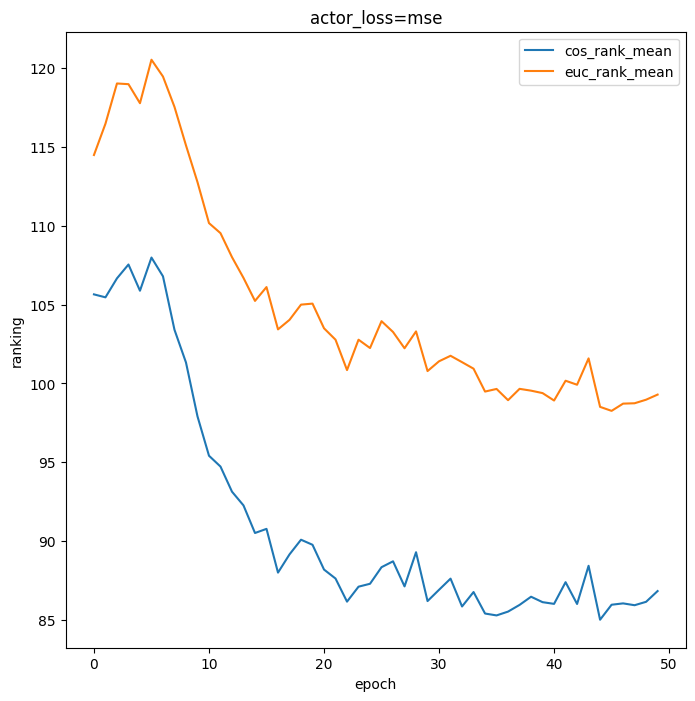

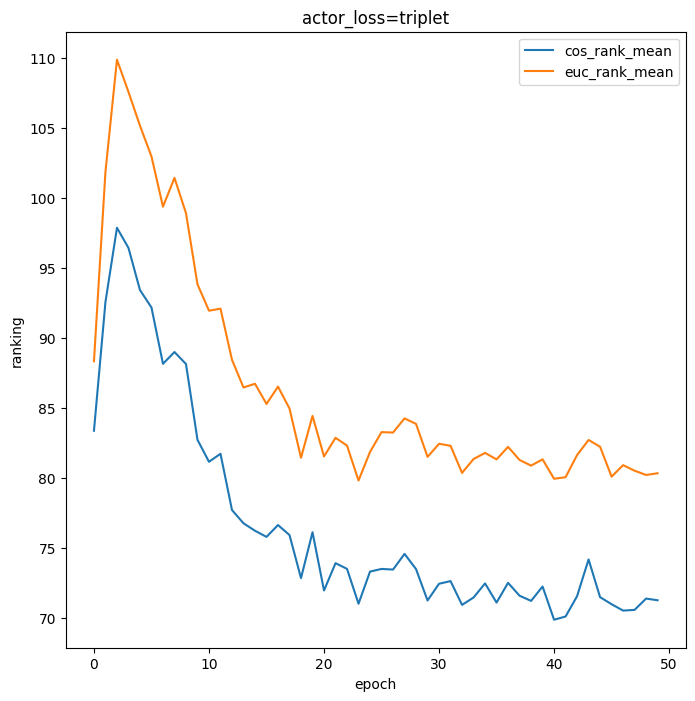

In [10]:
actor_lr = 3e-4
critic_lr = 1e-3
epochs = 50
batch_size = 128

for distance_metric, actor_loss_type, topk, emb_model_update in itertools.product(["euclidean"], ["mse", "triplet"], [10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    print(f"Training for actor loss = {actor_loss_type}")

    # Model inits
    model = ActorCritic().to(device)
    actor_optimizer = torch.optim.Adam(model.parameters(), lr=actor_lr)  
    critic_optimizer = torch.optim.Adam(model.parameters(), lr=critic_lr)  
    if actor_loss_type == "triplet": 
        actor_loss_criterion = WeightedRegularizedTriplet()
    elif actor_loss_type == "mse":
        actor_loss_criterion = nn.MSELoss()
    critic_loss_criterion = nn.MSELoss()
    
    # Embeddings init
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    embedding_model.load_state_dict(model.GIN.state_dict())
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)
    
    # Some helper inits
    best_rank = 10000
    best_model = None
    metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
                   "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}
    
    # Train the model
    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            actor_actions, critic_qs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])

            # Calc negatives
            negative_indices = []
            
            for _i in range(actor_actions.shape[0]):
                correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
                curr_out = actor_actions[_i].detach()
                dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
                sorted_idx = torch.argsort(dist)[:topk] # get topk
                sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                negative_indices.append(sorted_idx)
                
            # critic update
            batch_reactants = train_reactants[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
            batch_products = train_products[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
            batch_rsigs = action_rsigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
            batch_psigs = action_psigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
            batch_q_targets = torch.Tensor(sum([[1] + [0] * negative_indices[_i].shape[0] for _i in range(actor_actions.shape[0])], [])).view(-1, 1)

            
            critic_qs = model(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic")
            critic_loss = critic_loss_criterion(critic_qs, batch_q_targets.to(device))
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            # actor update
            actor_actions = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size], "actor")
            target_embeddings = get_action_embedding_from_packed_molecule(embedding_model, train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])
            if actor_loss_type == "mse":
                actor_loss = actor_loss_criterion(actor_actions, target_embeddings)
            elif actor_loss_type == "triplet":
                negatives = []
                for _indices in negative_indices:
                    negatives.append(action_embeddings[_indices])
                negatives = torch.concatenate(negatives, axis=0)

                # Calc loss
                batch_input = torch.concat([actor_actions, target_embeddings, negatives])
                labels = torch.concat([torch.arange(actor_actions.shape[0]), torch.arange(target_embeddings.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
                actor_loss = actor_loss_criterion(batch_input, labels)
            else:
                raise Exception(f"What is {actor_loss_type}?")
            
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            # Emptry any cache (free GPU memory)
            torch.cuda.empty_cache()

        print (f'Epoch {epoch}/{epochs}. Batch {i}/{train_reactants.batch_size - batch_size}. Actor loss = {actor_loss.item():.6f} || critic loss = {critic_loss.item():.6f}')#, end='\r')

        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# actor_loss = {actor_loss_type} | emb_model_update = {emb_model_update} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = torch.concatenate([model(test_reactants[i:i+batch_size], test_products[i:i+batch_size], test_rsigs[i:i+batch_size], test_psigs[i:i+batch_size])[0].detach() for i in range(0, test_reactants.batch_size-batch_size, batch_size)], axis=0)
            true = get_action_embedding_from_packed_molecule(embedding_model, test_rsigs[:pred.shape[0]], test_psigs[:pred.shape[0]]) #get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
            metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                    l.append(rank.item())
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
                metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
                metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

            metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()

        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

        # Update best model
        if metric_dict["euc_rank_mean"][-1] < best_rank:
            best_rank = metric_dict["euc_rank_mean"][-1]
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")

    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title(f"actor_loss={actor_loss_type}")
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()

    # save everything
    folder = f"models/supervised/actor-critic/emb_model_update={emb_model_update}||actor_loss={actor_loss_type}||steps={steps}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "steps(trajectory length)": steps,
        "actor_lr": actor_lr,
        "critic_lr": critic_lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "actor_loss": actor_loss_type,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        "best_rank": best_rank
    }, open(os.path.join(folder, "config.txt"), 'w'))
    print("Saved model at", folder)